In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Fix random seed
torch.manual_seed(777)

# if device == cuda fix seed
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/', # download root 다운로드 경로 지정
                          train=True, # True -> download as train data /True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # change as Tensor /텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # download root / 다운로드 경로 지정
                         train=False, # False -> download as Test data /False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # chnage as Tensor / 텐서로 변환
                         download=True)

In [5]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [6]:
class CNN(torch.nn.Module): # model CNN 

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [7]:
# Define CNN as model
model = CNN().to(device)

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # include softmax 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
#check total batch
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch)) 


총 배치의 수 : 600


In [10]:
# Training 
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # take as mini batch / X -> mini batch, Y is Label/  미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.190083876
[Epoch:    2] cost = 0.0520923622
[Epoch:    3] cost = 0.0368685164
[Epoch:    4] cost = 0.0296565648
[Epoch:    5] cost = 0.0244229715
[Epoch:    6] cost = 0.0198347457
[Epoch:    7] cost = 0.0171841942
[Epoch:    8] cost = 0.015027184
[Epoch:    9] cost = 0.0121732512
[Epoch:   10] cost = 0.0131117729
[Epoch:   11] cost = 0.0106035518
[Epoch:   12] cost = 0.00967564154
[Epoch:   13] cost = 0.00850949902
[Epoch:   14] cost = 0.00851259008
[Epoch:   15] cost = 0.00681357458


In [11]:
# Check default Acc
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9860999584197998


/home/swuser08/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/swuser08/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [24]:
#Check Default ACC and re-define
import random 
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random 
test_loss = 0
correct = 0
test_losses=[]
test_losses=[]
test_accuracy=[]
for data, target in data_loader:
    if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        
    
test_loss /= len(data_loader.dataset)
test_losses.append(test_loss)
acc=100. * float(correct.to(torch.device('cpu')).numpy())
print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
    test_loss, acc / len(data_loader.dataset)))
    
test_accuracy.append(acc / len(data_loader.dataset))

/tmp/ipykernel_1910844/1607376977.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test result: Average loss: 0.0058, Accuracy: 99.8067%



In [21]:
list(enumerate(model.modules())) # check model's components

[(0,
  CNN(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (fc1): Linear(in_features=2048, out_features=625, bias=True)
    (layer4): Sequential(
      (0): Linear(in_features=2048, out_features=625, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
    )
    (fc2): Linear(in_features=625, out_features=10, bias=True)
  )),
 (1,
  Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3

In [26]:
sh = (list(enumerate(model.modules()))[0][1].fc2).weight.shape  # copy fc2's Tensors to v

v = []
with torch.no_grad():
    
    for i in range(sh[0]):
        for j in range(sh[1]):
            v.append([i, j, (list(enumerate(model.modules()))[0][1].fc2).weight[i, j].item()])
        if i % 100 == 0:
            print(i)

0


In [27]:

v = sorted(v, key = lambda x : x[2])  #sorting
v.reverse()


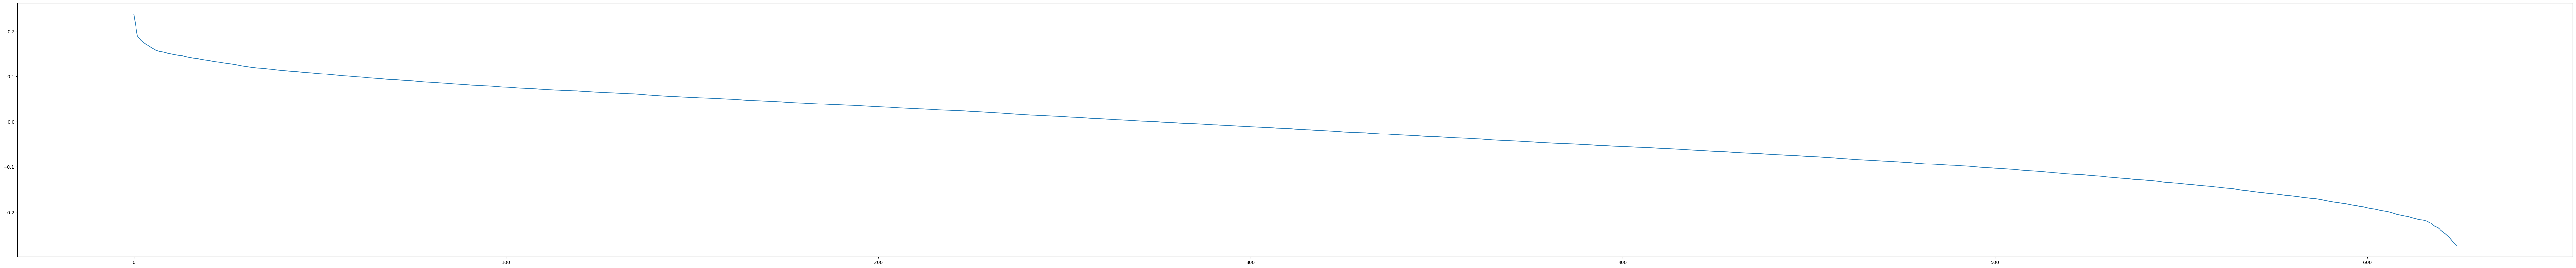

In [28]:
from matplotlib import pyplot as plt # check sorted weights
plt.figure(figsize=(100,10))
plt.plot(list(zip(*v[:10000:10]))[2])

In [29]:

correct_hist = []
sh = (list(enumerate(model.modules()))[0][1].fc2).weight.shape
layer = (list(enumerate(model.modules()))[0][1].fc2).weight

#num=int(4098*4098*(1/20))


num = 10
temp = 0
r = 0
value =0
with open("/home/swuser08/3DCNN_MNIST.txt", 'w') as f:
    for a in range(100):# total run NUM
        with torch.no_grad():
            test_loss = 0
            correct = 0
            test_losses=[]
            test_accuracy=[]
            r = random.randrange(0,num)
            temp = layer[v[r][0]][v[r][1]].clone()#copy the default value
            layer[v[r][0]][v[r][1]] = 10**random.randrange(3, 10)#*random.randrange(10,20) insert random weight value in random neruon which located in specific layer(fc2)         
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()))
            print("Fault injected: {:4d} {:4d} {:.5f}=>{:.5f}".format(v[r][0], v[r][1], v[r][2], layer[v[r][0]][v[r][1]].item()), file=f)
            
            for data, target in data_loader: # do test with fault
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                    data, target = Variable(data, volatile=True), Variable(target)
                    output = model(data)
                    test_loss += F.cross_entropy(output, target, size_average=False).item()
                    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                
            test_loss /= len(data_loader.dataset)
            test_losses.append(test_loss)
            acc=100. * float(correct.to(torch.device('cpu')).numpy())
            print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
                test_loss, acc / len(data_loader.dataset)))
            print('Fault Injected Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                test_loss, acc / len(data_loader.dataset)), file=f)
                
        for i in range(num): # Top n Neurons
            with torch.no_grad():
                # print(layer[v[i][0]][v[i][1]])
                test_loss = 0
                correct = 0
                test_losses=[]
                test_accuracy=[]
                target_temp = layer[v[i][0]][v[i][1]].clone() # # save fault value at target_temp 
                print(layer[v[i][0]][v[i][1]])
    #            value=target.item() ##save before value
                layer[v[i][0]][v[i][1]] = 0            
                for data, target in data_loader:
                    data, target = Variable(data, volatile=True), Variable(target)
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                        data, target = Variable(data, volatile=True), Variable(target)
                        output = model(data)
                        test_loss += F.cross_entropy(output, target, size_average=False).item()
                        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
                        
                    
                test_loss /= len(data_loader.dataset)
                test_losses.append(test_loss)
                acc=100. * float(correct.to(torch.device('cpu')).numpy())
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(data_loader.dataset)), file=f)
                print('{:4f} {:4f} Test result: Average loss: {:.4f}, Accuracy: {:.4f}%'.format(
                    a, i, test_loss, acc / len(data_loader.dataset)))

                test_accuracy.append(acc  / len(data_loader.dataset))
                correct_hist.append((i, j, correct, value))# the highest value and weight changed to 0 가장 높은 확률과, 0으로 바뀐 weight까지                
                    
                layer[v[i][0]][v[i][1]] = target_temp   # insert faulted value a gain
                if len(correct_hist) % 10 == 0: # check progress
                        print(correct_hist)
        with torch.no_grad():
            layer[v[r][0]][v[r][1]]=temp                #insert DEFAULT value a gain
        correct_hist = sorted(correct_hist, key = lambda x : abs(x[2]))  #sorting
        node_high = correct_hist[-1]# take index's max -> location, highest correct's time 
        node_low = correct_hist[0]
        print('{} when high: {}'.format(a, node_high))
        print('{} when high: {}'.format(a, node_high),file=f)

        print('{} when low: {}'.format(a, node_low))
        print('{} when low: {}'.format(a, node_low),file=f)
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(data_loader.dataset)*100))
        print('{} accuracy of the high network on the test images: {}'.format(a, node_high[2]/len(data_loader.dataset)*100),file=f)
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(data_loader.dataset)*100))
        print('{} accuracy of the low network on the test images'.format(a, node_low[2]/len(data_loader.dataset)*100),file=f)
        correct_hist = []

Fault injected:    2  206 0.20023=>10000000.00000


/tmp/ipykernel_1910844/3500541908.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test result: Average loss: 2863332.6883, Accuracy: 87.1483%

tensor(0.2366, device='cuda:0', requires_grad=True)


/tmp/ipykernel_1910844/3500541908.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/tmp/ipykernel_1910844/3500541908.py:57: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)


0.000000 0.000000 Test result: Average loss: 2823577.7606, Accuracy: 87.2667%
tensor(0.2330, device='cuda:0', requires_grad=True)
0.000000 1.000000 Test result: Average loss: 2800390.8813, Accuracy: 87.4417%
tensor(0.2269, device='cuda:0', requires_grad=True)
0.000000 2.000000 Test result: Average loss: 2823290.0940, Accuracy: 87.4867%
tensor(0.2184, device='cuda:0', requires_grad=True)
0.000000 3.000000 Test result: Average loss: 2800392.0333, Accuracy: 87.5367%
tensor(0.2153, device='cuda:0', requires_grad=True)
0.000000 4.000000 Test result: Average loss: 2791444.9473, Accuracy: 87.3917%
tensor(0.2070, device='cuda:0', requires_grad=True)
0.000000 5.000000 Test result: Average loss: 2833199.6743, Accuracy: 87.3033%
tensor(0.2022, device='cuda:0', requires_grad=True)
0.000000 6.000000 Test result: Average loss: 2797283.1213, Accuracy: 87.3650%
tensor(10000000., device='cuda:0', requires_grad=True)
0.000000 7.000000 Test result: Average loss: 0.0051, Accuracy: 99.8283%
tensor(0.1946, 